In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"

2023-08-11 07:25:59.143540: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 07:25:59.422507: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-11 07:25:59.483351: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-11 07:26:00.489095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

In [3]:
def generate_sample(sap, nean, den):
    list_before =  list(np.random.choice(sapiens_500_generated, sap)) + list(np.random.choice(neanderthals_500_generated, nean)) + list(np.random.choice(denisovan_500_samples, den))
    l = []
    for i in list_before:
        l.append(str(i))
    return l

In [4]:
sapiens = 5
neanderthals = 5
denisovans = 0

dataset_1 = generate_sample(sapiens, neanderthals, denisovans)

In [5]:
maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(dataset_1,
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  10
start working on read number 0


In [6]:
maximum_likelihood_calculator_d_1.estimate_species_proportions()

,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.475,0.525,0.0


In [7]:
from itertools import combinations

def find_all_subsets(group):
    all_subsets = []
    n = len(group)
    
    for r in range(n + 1):
        subsets_r = combinations(group, r)
        all_subsets.extend(list(subsets_r))
        
    return all_subsets

In [8]:
def calculate_shapley_values_for_datum(data_point, length_of_data, ml_calculator):
    indexes_without_datum = [i for i in range(length_of_data) if i != data_point]
    all_subsets = find_all_subsets(indexes_without_datum)
    sum_over_all_subsets = 0 
    for G in all_subsets:
        g_with = [i for i in G]
        g_with.append(data_point)
        with_datum = ml_calculator.calc_maximum_likelihood_on_subset(subset_of_indexes=g_with).values[0]
        without_datum = ml_calculator.calc_maximum_likelihood_on_subset(subset_of_indexes=G).values[0]
        with_minus_without = with_datum - without_datum
        multiplier = np.math.factorial(len(G)) * np.math.factorial(length_of_data - len(G) - 1)
        value_for_sum = with_minus_without * multiplier 
        sum_over_all_subsets += value_for_sum
    shapleys = sum_over_all_subsets / np.math.factorial(length_of_data)
    return  shapleys

In [ ]:
ground_truth_shapleys = []
for i in range(len(dataset_1)):
    print(i)
    ground_truth_shapleys.append(calculate_shapley_values_for_datum(i,len(dataset_1),maximum_likelihood_calculator_d_1))

0
1
2


1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1022
Start working on read number 0 in processId 353
Start working on read number 1 in processId 354
Start working on read number 2 in processId 355
Start working on read number 3 in processId 356Start working on read number 4 in processId 357
Start working on read number 5 in processId 358
Start working on read number 6 in processId 359

Start working on read number 7 in processId 360
Start working on read number 8 in processId 355
Start working on read number 9 in processId 357


In [55]:
shapley_values_monte_carlo

[array([[ 0.    , -0.0388, -0.0285,  0.4634,  0.    , -0.2026,  0.0007,
         -0.2106,  0.004 ,  0.    ]]),
 array([[ 0.    ,  0.0388,  0.0285, -0.4634,  0.    ,  0.2026, -0.0007,
          0.2106, -0.004 ,  0.    ]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]

In [16]:
ground_truth_shapleys

[array([-0.0255    ,  0.07061111, -0.04511111]),
 array([-0.08596627,  0.01996627,  0.066     ]),
 array([-0.0830496 ,  0.12816071, -0.04511111]),
 array([ 0.5182004 , -0.47308929, -0.04511111]),
 array([-0.01111508,  0.05622619, -0.04511111]),
 array([-0.2142996 ,  0.25941071, -0.04511111]),
 array([-0.02897222,  0.07408333, -0.04511111]),
 array([-0.2142996 ,  0.25941071, -0.04511111]),
 array([ 0.12611706, -0.08100595, -0.04511111]),
 array([-0.01111508,  0.05622619, -0.04511111])]

In [48]:
shaps

[array([[-0.01194444, -0.09146825, -0.08813492,  0.51353175, -0.0234127 ,
         -0.21646825, -0.00555556, -0.21646825,  0.12019841, -0.01027778]]),
 array([[ 0.05461111,  0.2       ,  0.13080159, -0.47086508,  0.06607937,
          0.25913492,  0.04822222,  0.25913492, -0.07753175,  0.05294444]]),
 array([[-0.04266667,  0.044     , -0.04266667, -0.04266667, -0.04266667,
         -0.04266667, -0.04266667, -0.04266667, -0.04266667, -0.04266667]])]

In [47]:
a_s_d[0][0]

[0.16999989037650481,
 -0.06424012157879294,
 0.13140795756860968,
 0.6696065899022112,
 0.1699240034541737,
 -0.32939248933844206,
 0.0449861379546187,
 -0.3299514707569916,
 0.1773825495983548,
 0.16999751097076016]

In [36]:
shaps[2]

array([[-0.04266667,  0.044     , -0.04266667, -0.04266667, -0.04266667,
        -0.04266667, -0.04266667, -0.04266667, -0.04266667, -0.04266667]])

In [43]:
def accuracy_shap(shap_values, ground_truth):
    count_correct = 0
    count = 0
    for label in range(3):
        
        first_label_shaps = shaps[label][0]
        first_label_gt = [i[label] for i in ground_truth]
        for i in range(len(first_label_gt)):
            if(first_label_shaps[i] * first_label_gt[i] > 0):
                count_correct +=1
            count +=1
    return count_correct / count
    
    
    

In [49]:
def accuracy_a_d_s(a_d_s_values, ground_truth):
    count_correct = 0
    count = 0
    for label in range(3):
        first_label_a_d = a_d_s_values[label][0]
        first_label_gt = [i[label] for i in ground_truth]
        for i in range(len(first_label_gt)):
            if(first_label_a_d[i] * first_label_gt[i] > 0):
                count_correct +=1
            count +=1
    return count_correct / count
    

In [56]:
def accuracy_monte_carlo(monte_carlo_values, ground_truth):
    count_correct = 0
    count = 0
    for label in range(3):
        first_label_monte = monte_carlo_values[label][0]
        first_label_gt = [i[label] for i in ground_truth]
        for i in range(len(first_label_gt)):
            if(first_label_monte[i] * first_label_gt[i] > 0):
                count_correct +=1
            count +=1
    return count_correct / count

In [65]:
data_shap = []
data_monte = []
data_a_s_d = []

In [67]:
for num in range(1,10):
    shaps = maximum_likelihood_calculator_d_1.calculate_shapley_values(num)
    shapley_values_monte_carlo = maximum_likelihood_calculator_d_1.estimate_shapley_values(number_of_samples_per_read = num)[1]
    a_s_d = maximum_likelihood_calculator_d_1.get_A_s_d_values()
    a_s_d = maximum_likelihood_calculator_d_1.get_A_s_d_values()
    first = [a[0]-0.33 for a in a_s_d ]
    second = [a[1]-0.33 for a in a_s_d ]
    thirs = [a[2]-0.33 for a in a_s_d ]
    a_s_d_values = [[first], [second], [thirs]]
    sign_accuracy_shap = accuracy_shap(shaps, ground_truth_shapleys)
    sign_accuracy_monte_carlo = accuracy_monte_carlo(shapley_values_monte_carlo, ground_truth_shapleys)
    sign_accuracy_a_s_d = accuracy_a_d_s(a_s_d_values, ground_truth_shapleys)
    
    data_shap.append((num, sign_accuracy_shap))
    data_monte.append((num, sign_accuracy_monte_carlo))
    data_a_s_d.append((num, sign_accuracy_a_s_d))
                     
    print("shap", sign_accuracy_shap)
    print("monte carlo", sign_accuracy_monte_carlo)    
    print("asd",sign_accuracy_a_s_d)    

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1
Start working on read number 0 in processId 2052Start working on read number 1 in processId 2053

Start working on read number 2 in processId 2054
Start working on read number 3 in processId 2055Start working on read number 4 in processId 2056
Start working on read number 5 in processId 2057Start working on read number 6 in processId 2058
Start working on read number 7 in processId 2059


Start working on read number 8 in processId 2053Start working on read number 9 in processId 2058

shap 0.0
monte carlo 0.26666666666666666
asd 0.8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
2
Start working on read number 0 in processId 2136
Start working on read number 1 in processId 2137Start working on read number 2 in processId 2138

Start working on read number 3 in processId 2139
Start working on read number 5 in processId 2141Start working on read number 4 in processId 2140

Start working on read number 6 in processId 2142
Start working on read number 7 in processId 2143
Start working on read number 8 in processId 2136
Start working on read number 9 in processId 2140
shap 0.03333333333333333
monte carlo 0.2
asd 0.8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
3
Start working on read number 0 in processId 2220Start working on read number 1 in processId 2221

Start working on read number 2 in processId 2222Start working on read number 3 in processId 2223
Start working on read number 4 in processId 2224
Start working on read number 5 in processId 2225

Start working on read number 6 in processId 2226
Start working on read number 7 in processId 2227
Start working on read number 8 in processId 2221
Start working on read number 9 in processId 2227
shap 0.13333333333333333
monte carlo 0.3333333333333333
asd 0.8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
4
Start working on read number 0 in processId 2304
Start working on read number 1 in processId 2305
Start working on read number 2 in processId 2306
Start working on read number 3 in processId 2307
Start working on read number 4 in processId 2308
Start working on read number 5 in processId 2309
Start working on read number 6 in processId 2310
Start working on read number 7 in processId 2311
Start working on read number 8 in processId 2304
Start working on read number 9 in processId 2309
shap 0.1
monte carlo 0.3333333333333333
asd 0.8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5
Start working on read number 0 in processId 2388
Start working on read number 1 in processId 2389
Start working on read number 2 in processId 2390
Start working on read number 3 in processId 2391Start working on read number 4 in processId 2392Start working on read number 6 in processId 2394Start working on read number 5 in processId 2393
Start working on read number 7 in processId 2395



Start working on read number 8 in processId 2391Start working on read number 9 in processId 2390

shap 0.16666666666666666
monte carlo 0.3333333333333333
asd 0.8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
6
Start working on read number 0 in processId 2479Start working on read number 1 in processId 2480

Start working on read number 2 in processId 2481
Start working on read number 3 in processId 2482
Start working on read number 4 in processId 2483Start working on read number 6 in processId 2485
Start working on read number 5 in processId 2484Start working on read number 7 in processId 2486


Start working on read number 8 in processId 2479
Start working on read number 9 in processId 2482
shap 0.3
monte carlo 0.3333333333333333
asd 0.8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
7
Start working on read number 0 in processId 2570
Start working on read number 1 in processId 2571
Start working on read number 2 in processId 2572
Start working on read number 3 in processId 2573Start working on read number 4 in processId 2574Start working on read number 5 in processId 2575Start working on read number 6 in processId 2576
Start working on read number 7 in processId 2577



Start working on read number 8 in processId 2571
Start working on read number 9 in processId 2572
shap 0.23333333333333334
monte carlo 0.3333333333333333
asd 0.8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
8
Start working on read number 0 in processId 2661Start working on read number 1 in processId 2662

Start working on read number 2 in processId 2663
Start working on read number 3 in processId 2664Start working on read number 4 in processId 2665
Start working on read number 5 in processId 2666Start working on read number 7 in processId 2668

Start working on read number 6 in processId 2667

Start working on read number 8 in processId 2663
Start working on read number 9 in processId 2664
shap 0.2
monte carlo 0.3333333333333333
asd 0.8
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
9
Start working on read number 0 in processId 2752
Start working on read number 1 in processId 2753Start working on read number 2 in processId 2754

Start working on read number 3 in processId 2755Start working on read number 4 in processId 2756
Start working on read number 5 in processId 2757

Start working on read number 6 in processId 2758Start working on read number 7 in processId 2759

Start working on read number 8 in processId 2754
Start working on read number 9 in processId 2756
shap 0.16666666666666666
monte carlo 0.3333333333333333
asd 0.8


In [20]:
a_s_d

[[[0.16999989037650481,
   -0.06424012157879294,
   0.13140795756860968,
   0.6696065899022112,
   0.1699240034541737,
   -0.32939248933844206,
   0.0449861379546187,
   -0.3299514707569916,
   0.1773825495983548,
   0.16999751097076016]],
 [[0.16999989037650481,
   0.03712006078939645,
   0.2082820079687781,
   -0.32999979778352734,
   0.1699240034541737,
   0.6693924598407637,
   0.0449861379546187,
   0.6694695860665383,
   0.16249775543709022,
   0.16999751097076016]],
 [[-0.3299997807530097,
   0.03712006078939645,
   -0.32968996553738783,
   -0.32960679211868393,
   -0.3298480069083475,
   -0.3299999705023215,
   -0.0799722759092375,
   -0.3295181153095468,
   -0.32988030503544513,
   -0.3299950219415203]]]

In [63]:
def plot(t,s, name, title):

    plt.rcParams.update({'font.size': 14})
    plt.plot(t, s)
    plt.title(title)
    plt.xlabel("Number of samples per sequence")
    plt.ylabel("Percentage of correct explanation values")
    
    plt.savefig(name)

    plt.show()

In [64]:
import time


<Figure size 640x480 with 0 Axes>

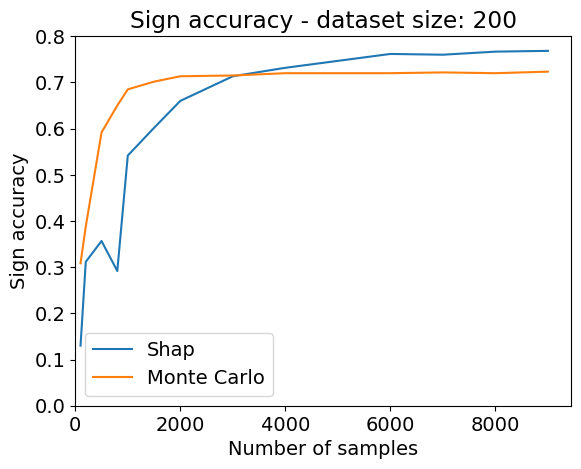

In [84]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure() 
plt.figure().clear()
plt.rcParams.update({'font.size': 14})
t = [i[0] for i in data_shap]
plt.plot(t,[i[1] for i in data_shap],label='Shap')
plt.plot(t,[i[1] for i in data_monte_carlo ],label='Monte Carlo')
plt.title("Sign accuracy - dataset size: 200")
plt.xlabel("Number of samples")
plt.ylabel("Sign accuracy")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.savefig("sign_accuracy_shap_200.png")
plt.show()

